In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('../')
sys.path.append('/usr/users/fsimone/tejaas')
from iotools import readgtf

base_dir = "/cbscratch/franco/datasets"

import collections

GENEINFO_FIELDS = ['name', 'ensembl_id', 'chrom', 'start', 'end']
class GeneInfo(collections.namedtuple('_GeneInfo', GENEINFO_FIELDS)):
    __slots__ = ()

def read_TFannot(infile):
    TF_list = list()
    with open(infile) as instream:
        next(instream)
        for line in instream:
            arr = line.rstrip().split()
            TF_list.append(GeneInfo(ensembl_id=arr[0], chrom=int(arr[1]), start=int(arr[2]), end=int(arr[3]), name=arr[4]))
    return TF_list

TF_annot = read_TFannot("../TF_annotation.txt")

import collections
TF_dict = collections.defaultdict(dict)
for g in TF_annot:
    TF_dict[g.chrom][g.ensembl_id] = g.start
    
def search_TF(TF_dict, chrom, pos):
    TSS_distance = 1e10
    cisTF = None
    found = False
    for TF in TF_dict[chrom].keys():
        dist = pos - TF_dict[chrom][TF]
        if np.abs(dist) < TSS_distance:
            TSS_distance = dist
            cisTF = TF
            found = True
    if not found:
        print(chrom, pos)
    return TSS_distance, cisTF

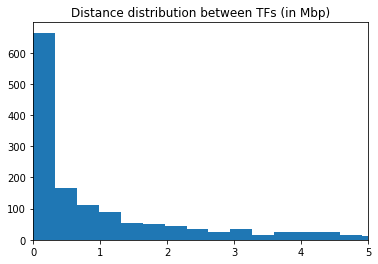

In [28]:
# Distances between contiguous TFs
import matplotlib.pyplot as plt

dists = list()
prev = TF_annot[0]
for e in TF_annot[1:]:
    if prev.chrom == e.chrom:
        dists.append(e.start - prev.start)
    prev = e 
dists = np.array(dists)

plt.hist(dists / 1000000, bins=100)
plt.xlim(0,5)
plt.title("Distance distribution between TFs (in Mbp)")
plt.show()

In [14]:
import mpmath

mpmath.mp.dps = 500
def pval(x): return float(mpmath.log10(1 - 0.5 * (1 + mpmath.erf(x/mpmath.sqrt(2)))))

SNPRES_FIELDS = ['rsid', 'chrom', 'pos', 'pval', 'TFdist', 'TFname']
class SNPRes(collections.namedtuple('_SNPRes', SNPRES_FIELDS)):
    __slots__ = ()
        
def tejaas(filepath, chrom):
    res = list()
    with open(filepath, 'r') as mfile:
        next(mfile)
        for line in mfile:
            arr   = line.strip().split("\t")
            rsid  = arr[0]
            pos   = int(arr[1])
            p     = float(arr[5])
            q     = float(arr[2])
            mu    = float(arr[3])
            sigma = float(arr[4])
            res.append(SNPRes(rsid=rsid, chrom=chrom, pos=pos, pval=p, TFdist=None, TFname=None))
    return res

In [15]:
datadir = "/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v6_norm"
chrms = np.arange(1,23)
snp_res_dict = collections.defaultdict(dict)
snp_res_dict_top = collections.defaultdict(dict)
tissues = ["gtex-ms"]
expressions = ["norm"] #, "lmcorrected_age", "peer/20/covar_withage"]
sbs = ["0.05"]
methods = ["tejaas"]
for sb in sbs:
    for expr in expressions:
        snp_res_dict[sb][expr] = collections.defaultdict(dict)
        snp_res_dict_top[sb][expr] = collections.defaultdict(dict)
        for tissue in tissues:
            snp_res_dict[sb][expr][tissue] = collections.defaultdict(dict)
            snp_res_dict_top[sb][expr][tissue] = collections.defaultdict(dict)
            for method in methods:
                snp_res = list()
                snp_res_top = list()
                print(tissue, method, expr, end=" ")
                for chrom in chrms:
                    print(chrom, end=" ")
                    inputfile = datadir+"/"+expr+"/"+tissue+"/"+method+"/permnull_sb"+sb+"/chr"+str(chrom)+"/rr.txt"
                    snp_res += tejaas(inputfile, chrom)

                    # inputfile = datadir+"/"+expr+"/"+tissue+"/"+method+"/permnull_sb"+sb+"/chr"+str(chrom)+"/rr.txt.top2000"
                    # snp_res_top += tejaas(inputfile, chrom)
                print("")
                snp_res_dict[sb][expr][tissue][method] = snp_res
                # snp_res_dict_top[sb][expr][tissue][method] = snp_res_top

gtex-ms tejaas norm 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 


In [17]:
nsnps = 1000
window = 1e6
Numbins = 50
mymethod = "tejaas"
myexpr   = "norm" # "peer/20/covar_withage" #
mytissue = "gtex-ms"
mysb = "0.05"
allsnplist = snp_res_dict[mysb][myexpr][mytissue][mymethod]
print("Nº of SNPs: {:d}".format(len(allsnplist)))

Nº of SNPs: 4109737


In [29]:
allTSSdists = list()
for snp in allsnplist:
    TSS_distance, cisTF = search_TF(TF_dict, snp.chrom, snp.pos)
    np.append(allTSSdists, TSS_distance)

In [ ]:
allTSSdists